# Mapping to Pre-built Symphony References

Last edited March 13, 2021.

In this tutorial, we will show how to map new query datasets onto pre-built Symphony references.

**Pre-built references available for download:**

| Reference atlas | File | Num cells | Description
| --- | ----------- | --------- | ----
|  Atlas of 10x PBMCs | pbmcs_10x_reference.rds | 20,792 cells | Sequenced with three 10x protocols (3'v1, 3'v2, and 5')
| Atlas of human pancreatic islet cells | pancreas_plate-based_reference.rds | 5,887 cells, 32 donors | From four separate studies
| Atlas of human fetal liver hematopoeisis | fetal_liver_reference_3p.rds | 113,063 cells, 14 donors | From Popescu et al. (*Nature* 2019), sequenced with 10x 3' chemistry
| Multimodal atlas of Memory T cells | -- | 500,089 cells, 271 samples | CITE-seq; to be released upon publication

To read in a reference into R, one may simply execute: `reference = readRDS('path/to/reference_name.rds')`

## Imports

Visit https://github.com/immunogenomics/symphony for information about installing Symphony.

In [3]:
devtools::install_github("immunogenomics/symphony", dep = FALSE, force = TRUE) # whether to update dependencies

✔  checking for file ‘/tmp/RtmpASEsJ6/remotes952f365dbdb/immunogenomics-symphony-0b2a4f8/DESCRIPTION’
─  preparing ‘symphony’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘symphony_1.0.tar.gz’
   


In [4]:
suppressPackageStartupMessages({
    source('libs.R') # imports
    source('utils.R') # useful functions and plotting color definitions
})

# Loading the 10x PBMCs atlas

This section gives an example of how to load and plot a Symphony reference. Here, we load in an integrated reference of PBMCs sequenced using different 10x technologies.

In [5]:
# Read in saved reference
reference_pbmcs = readRDS('../pre-built_references/pbmcs_10x_reference.rds')

To plot the reference as density plots, use the `plotReference` function with `as.density = TRUE`.

Adding missing grouping variables: `cell_type`


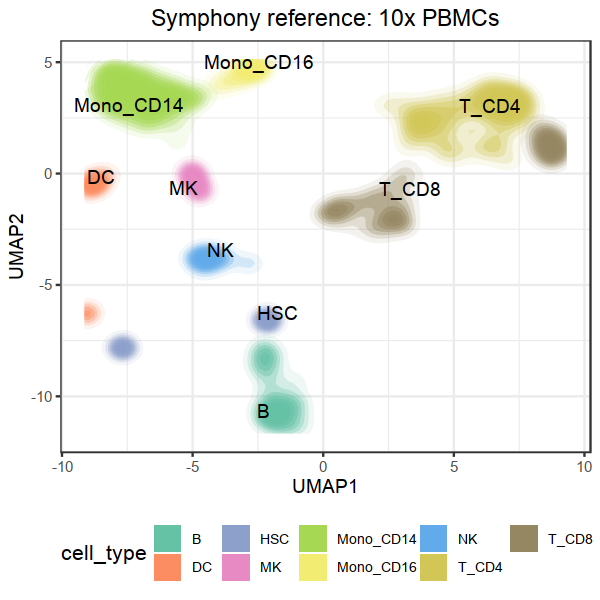

In [6]:
fig.size(5, 5)
plotReference(reference_pbmcs,
                title = "Symphony reference: 10x PBMCs",    # Plot title
                color.by = 'cell_type',                     # metadata column name for cell type labels
                celltype.colors = pbmc_colors)              # custom color palette)

To plot the reference as individual points, use the `plotReference` function with `as.density = FALSE`.

Adding missing grouping variables: `cell_type`


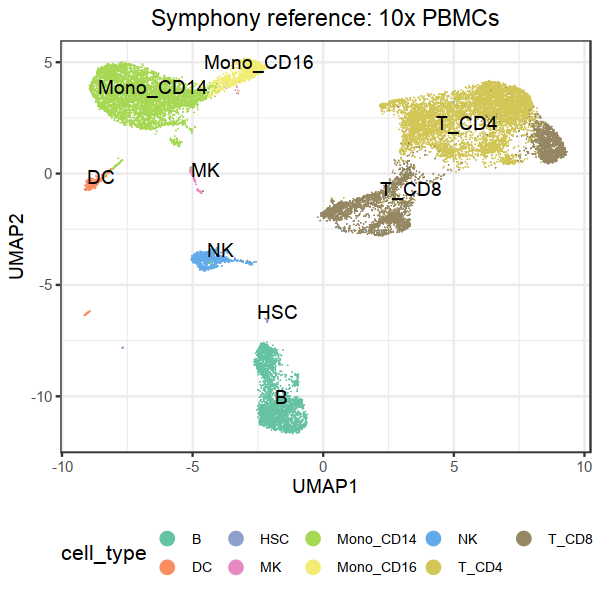

In [7]:
fig.size(5, 5)
plotReference(reference_pbmcs,
                as.density = FALSE,
                title = "Symphony reference: 10x PBMCs",    # Plot title
                color.by = 'cell_type',                     # metadata column name for cell type labels
                celltype.colors = pbmc_colors)              # custom color palette)

Let's take a look at what is included in each reference object:

In [8]:
str(reference_pbmcs)

List of 10
 $ meta_data     :'data.frame':	20571 obs. of  10 variables:
  ..$ cell_id         : Factor w/ 20886 levels "fivePrime_AAACCTGAGCGATAGC",..: 7698 7699 7700 7701 7702 7703 7704 7705 7706 7707 ...
  ..$ donor           : Factor w/ 3 levels "5p","3pv2","3pv1": 2 2 2 2 2 2 2 2 2 2 ...
  ..$ nUMI            : int [1:20571] 2394 1694 4520 2788 4667 4440 3224 5205 5493 4419 ...
  ..$ nGene           : int [1:20571] 871 806 1316 898 1526 1495 1253 1433 1632 1134 ...
  ..$ percent_mito    : num [1:20571] 0.0384 0.0573 0.0195 0.014 0.0362 ...
  ..$ pub_cell_type   : Factor w/ 7 levels "","bcells","dc",..: 2 5 7 7 5 5 7 7 5 7 ...
  ..$ pub_res0.8      : int [1:20571] 3 5 2 1 0 0 6 4 0 4 ...
  ..$ pub_cell_subtype: Factor w/ 16 levels "","adc","bmem",..: 4 12 5 6 12 12 7 9 12 9 ...
  ..$ nnk5_res0.8     : chr [1:20571] "4" "1" "2" "0" ...
  ..$ cell_type       : chr [1:20571] "B" "Mono_CD14" "T_CD4" "T_CD4" ...
 $ vargenes      : tibble [2,357 × 3] (S3: tbl_df/tbl/data.frame)
  ..$ symb

The `meta_data` slot contains cell type annotations and other information.

In [9]:
reference_pbmcs$meta_data %>% head(4)

cell_id,donor,nUMI,nGene,percent_mito,pub_cell_type,pub_res0.8,pub_cell_subtype,nnk5_res0.8,cell_type
<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>
threepfresh_AAACCTGAGCATCATC,3pv2,2394,871,0.03842941,bcells,3,bnaive,4,B
threepfresh_AAACCTGAGCTAACTC,3pv2,1694,806,0.05726092,mono,5,mono14,1,Mono_CD14
threepfresh_AAACCTGAGCTAGTGG,3pv2,4520,1316,0.01946903,tcells,2,cd4mem,2,T_CD4
threepfresh_AAACCTGCACATTAGC,3pv2,2788,898,0.01398852,tcells,1,cd4naive,0,T_CD4


The `Z_corr` slot contains the harmonized reference embedding.

In [10]:
reference_pbmcs$Z_corr %>% t() %>% head() # transposed here for viewing

3.716486,12.87292164,4.572773356,1.358384,0.7626332,-0.17462929,-0.2036242,-1.91647752,-0.4457690,-1.5144360,-0.5769456,-0.787664674,0.4695417,-0.67121888,-0.23825125,0.9571981,1.6773047,-1.0778805,-1.5648311,3.0856541
-11.730078,-0.44977741,-2.339538199,1.542566,1.3580565,-3.27459142,1.0255415,-3.21094846,0.8090265,-0.2985241,0.4129421,-1.861355013,1.7653410,-0.05812879,0.15441929,2.8839834,0.2808740,-0.2299804,1.5982703,3.5028638
4.403666,-2.96992465,-3.772566846,-1.386480,-0.0707673,3.43689670,-2.2686995,-0.01951111,-2.7503068,1.3391445,-0.9737396,0.461454138,-2.3310515,1.38252789,-1.70297016,0.8089736,-0.1843712,0.9302084,0.3232930,1.2338821
6.346387,-0.75448889,-4.360558748,1.373370,0.3467606,0.05892304,-0.5800240,-1.44008575,1.2946803,-0.1620594,0.6010673,0.354090567,-0.5639480,0.63153259,0.06377888,0.5781766,-0.5459954,-0.1618203,0.4436729,-0.0972809
-15.188847,0.25733338,-0.005406742,1.282503,-0.4868483,1.39511048,-2.2172810,0.94498238,0.6825776,0.2093771,0.3129956,0.321376693,0.5442656,-0.59880438,0.23036179,-0.7752734,0.2730065,-0.8240925,-0.6673267,2.0978854
-14.020838,-0.06813117,-0.747157936,1.423980,0.4662320,-0.91600140,0.4942452,-1.97376186,-1.5777463,1.4739186,1.7716213,-0.003167562,-0.4467406,-0.59172009,0.37603314,-0.6983859,1.1461171,0.3932719,0.5000448,-0.6111727


Note: In order to map query cells onto the reference UMAP coordinates (e.g. to visualize reference and query cells together), you will need to save the path to the corresponding reference uwot_model file in the reference object's reference$save_uwot_path slot in order to load the uwot model for query mapping. This is due to a technicality of how the uwot package saves and loads UMAP models. If you only wish to map the query cells into the harmonized reference embedding (and compute your own separate UMAP embedding for visualization), you may ignore this step.

# Mapping to pancreatic islet atlas

## Load and view the reference

In this example, the reference consists of human pancreatic islet cells from 4 studies, each using a different plate-based technology.

In [11]:
# Read in saved reference
reference_pancreas = readRDS('../pre-built_references/pancreas_plate-based_reference.rds')

Adding missing grouping variables: `cell_type`


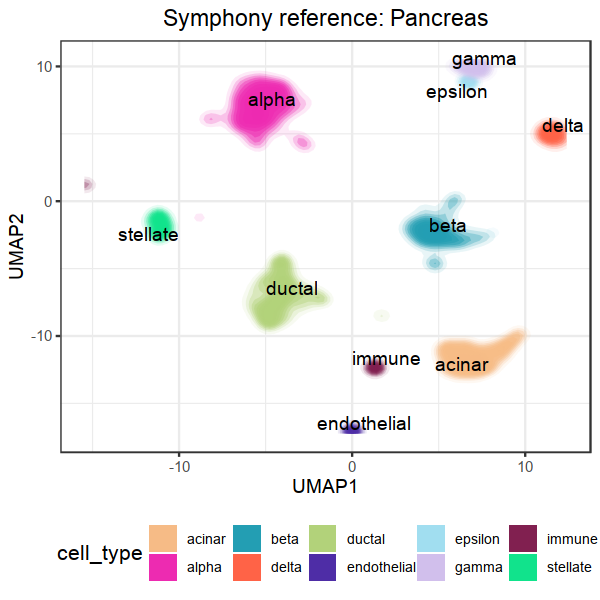

In [12]:
fig.size(5, 5)
plotReference(reference_pancreas,
                   title = "Symphony reference: Pancreas",    # Plot title
                   color.by = 'cell_type',                    # metadata column name for cell type labels
                   celltype.colors = celltype.colors)         # custom color palette

## Map an example query dataset

In this example, we will map the Baron et al. (2016) dataset containing human and mouse pancreatic islet cells sequenced using inDrop.

The mouse expression was "humanized" using a custom ortholog mapping generated from combining mouse and human gene ortholog pairs from Ensembl (accessed via biomaRt) and NCBI Homologene from https://ftp.ncbi.nih.gov/pub/HomoloGene/build37.2/homologene.data

In [13]:
# Read in query normalized expression for human and mouse
human_exp_norm = readRDS('data/pancreas_baron_human_exp.rds')
mouse_exp_norm = readRDS('data/pancreas_baron_mouse_biomart_homologene_exp.rds')

dim(human_exp_norm)
dim(mouse_exp_norm)

[1] 20125  8569

[1] 20873  1886

In [14]:
# Read in query metadata
human_metadata = readRDS('data/pancreas_baron_human_metadata.rds')
mouse_metadata = readRDS('data/pancreas_baron_mouse_metadata.rds')
human_metadata %>% head(4)
mouse_metadata %>% head(4)

,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
human1_lib1.final_cell_0001,1,acinar,3526,acinar,human,inDrop,human1
human1_lib1.final_cell_0002,1,acinar,4201,acinar,human,inDrop,human1
human1_lib1.final_cell_0003,1,acinar,2119,acinar,human,inDrop,human1
human1_lib1.final_cell_0004,1,acinar,2956,acinar,human,inDrop,human1


,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
mouse1_lib1.final_cell_0001,1,beta,3205,beta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0002,1,ductal,3829,ductal,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0003,1,delta,2582,delta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0004,1,schwann,3041,schwann,mouse,inDrop,mouse1


In [15]:
# To map the human and mouse simultaneously, combine the two sparse matrices
combined_filled = t(plyr::rbind.fill.matrix(t(mouse_exp_norm), t(human_exp_norm)))

# Fill in any missing genes with 0
combined_filled[is.na(combined_filled)] = 0
colnames(combined_filled) = c(rownames(mouse_metadata), rownames(human_metadata))
dim(combined_filled)

[1] 26000 10455

Perform the mapping

In [20]:
# Symphony mapping
system.time({
query = mapQuery(exp_query = combined_filled, 
                        metadata_query = rbind(mouse_metadata, human_metadata),
                        ref_obj = reference_pancreas,
                        vars = c('dataset', 'species', 'species_donor'), 
                        do_normalize = FALSE)
})

Scaling and synchronizing query gene expression
Found 2236 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


   user  system elapsed 
 14.301   7.015   9.963 

## Plot query after mapping

Plot query in reference UMAP coordinates

In [21]:
# Add UMAP coordinates
umap_labels = cbind(query$meta_data, query$umap)

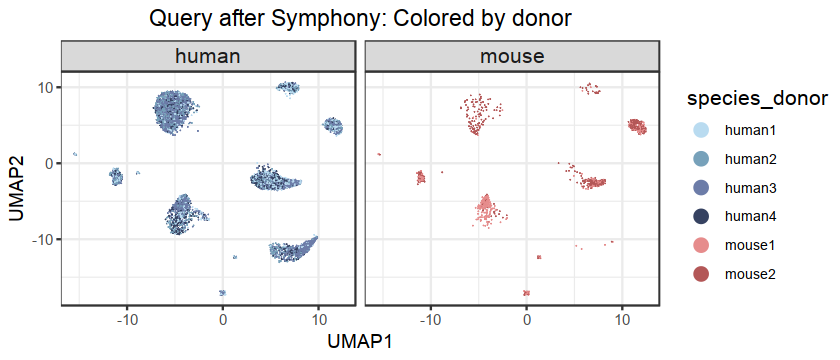

In [22]:
fig.size(3, 7)
plotBasic(umap_labels,
          title = 'Query after Symphony: Colored by donor',
          color.by = 'species_donor', facet.by = 'species',
          color.mapping = querydonor.colors)

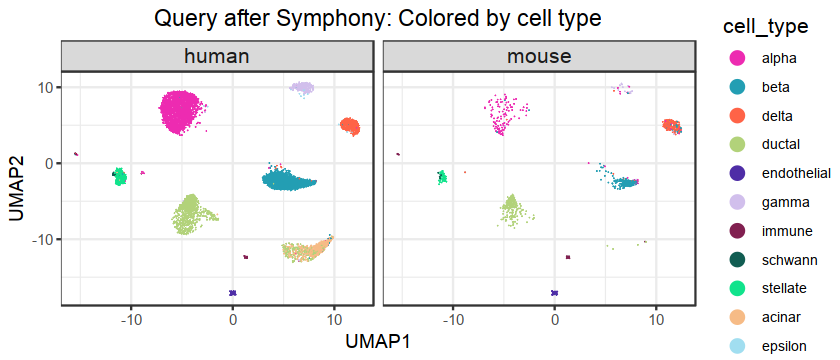

In [23]:
plotBasic(umap_labels,
          title = 'Query after Symphony: Colored by cell type',
          color.by = 'cell_type', facet.by = 'species',
          color.mapping = celltype.colors)

# Mapping to fetal liver hematopoiesis atlas

In this example, the reference consists of human fetal liver cells (Popescu et al. 2019), sequenced with 10x 3' chemistry. We will load this reference then map a query containing fetal liver cells sequenced with 10x 5' chemistry, then infer query cell types from the reference.

## Load and view the reference

In [24]:
# Read in saved reference
reference_fetal_liver = readRDS('../pre-built_references/fetal_liver_reference_3p.rds')

Adding missing grouping variables: `cell.labels`


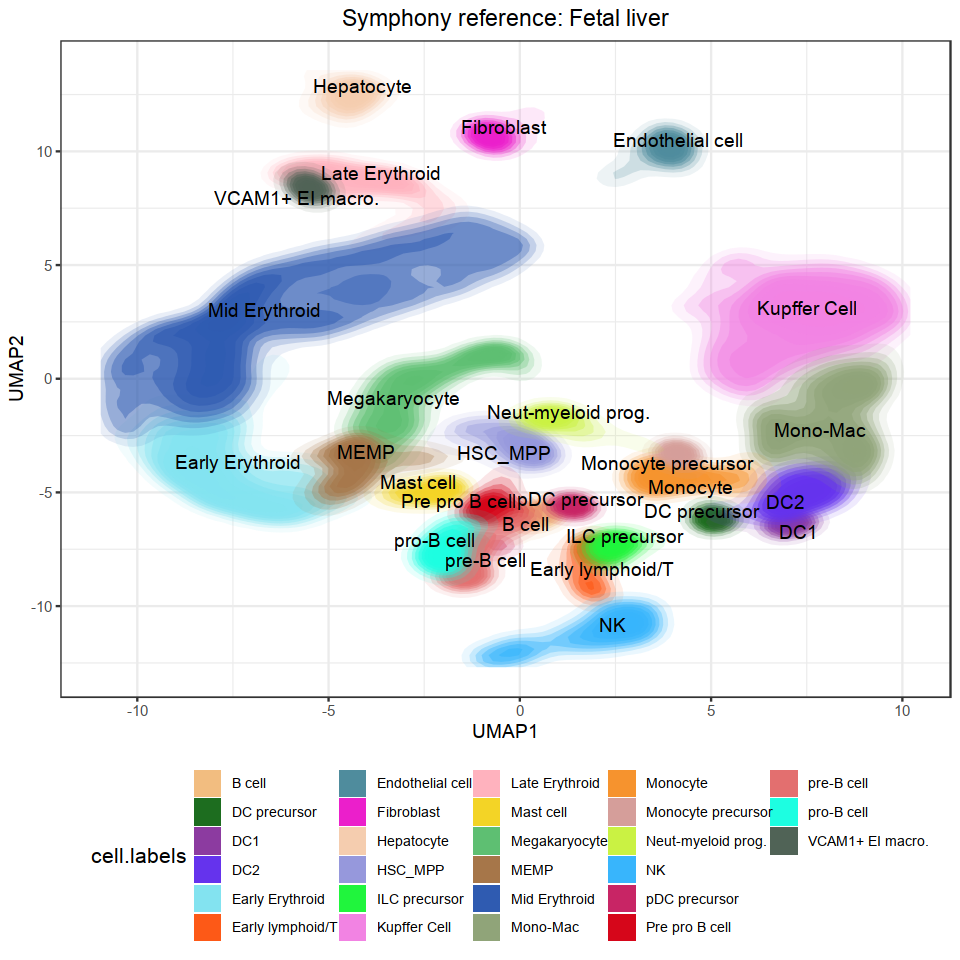

In [25]:
fig.size(8, 8)
plotReference(reference_fetal_liver,
                   title = "Symphony reference: Fetal liver",    # Plot title
                   color.by = 'cell.labels', # metadata column name for cell type labels
                   celltype.colors = group.colors) # custom color palette

## Map an example query dataset
We will map fetal liver cells sequenced with 10x 5' chemistry onto the atlas of cells sequenced with 3' chemistry.

In [31]:
# Read in 5-prime dataset
exprs_5p = readRDS('/data/srlab2/jkang/symphony_reproducibility/data/Fig5_fetal_liver/exprs_5sync_filtered.rds')
metadata_5p = readRDS('data/fetal_liver_meta_5p.rds') # from authors
dim(exprs_5p)
dim(metadata_5p)

[1] 33694 21414

[1] 21414    14

In [ ]:
# Map query
ptm <- proc.time()
query = mapQuery(exprs_5p, metadata_5p, reference_fetal_liver, 
                 vars = c('donor', 'end.bias'), 
                 do_normalize = TRUE)
proc.time() - ptm

## Plot query after mapping

Now, we can view our query and reference cells plotted in the reference embedding space, colored by author-defined cell type.

In [ ]:
# Sync column names
r_metadata = reference_fetal_liver$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
q_metadata = query$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
colnames(q_metadata) = colnames(r_metadata)

# Add reference vs. query labels
r_metadata$ref_query = 'reference'
q_metadata$ref_query = q_metadata$donor
meta_data_combined = rbind(q_metadata, r_metadata)

In [ ]:
# Add the UMAP coordinates to the metadata
umap_combined = rbind(query$umap, reference_fetal_liver$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined) %>% 
                mutate(cell.labels = fct_relevel(cell.labels, group.ordering))

In [27]:
umap_combined_labels %>% head(4)

ERROR: Error in head(., 4): object 'umap_combined_labels' not found


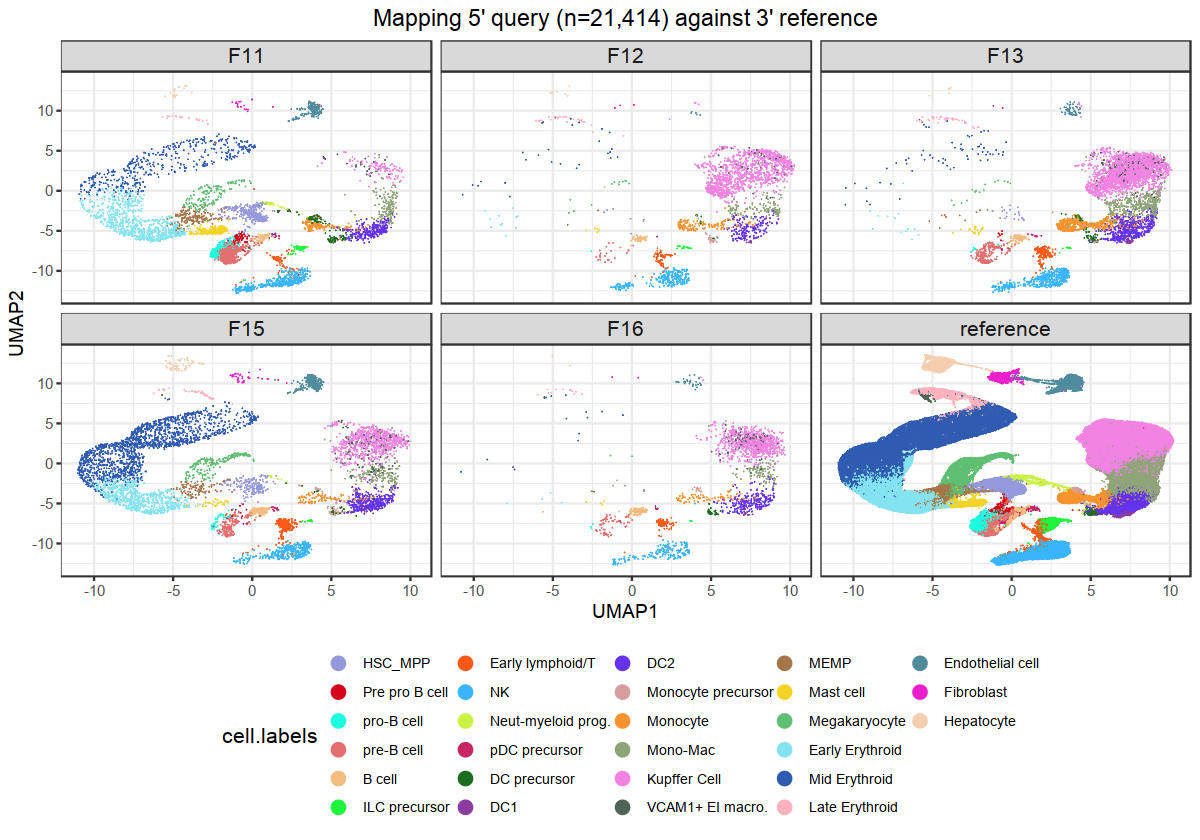

In [31]:
fig.size(7, 10)
plotBasic(umap_combined_labels,
          title = 'Mapping 5\' query (n=21,414) against 3\' reference',
          color.by = 'cell.labels', facet.by = 'ref_query',
          color.mapping = group.colors, legend.position = 'bottom')

## Cell type annotation transfer


Perform k-NN cell type prediction across 27 fine-grained continuous cell states

In [25]:
# Predict query cell types
query = knnPredict(query, reference_fetal_liver, 
                   train_labels = reference_fetal_liver$meta_data$cell.labels, 
                   k = 30)

Prediction results are stored in `query$meta_data$cell_type_pred_knn`

In [28]:
query$meta_data %>% head(4)

index,cell_barcode,Source.Name,pcw,sex,organ,donor,trimester,facs.sorting,end.bias,num_cells,nGene,cell.labels.public,cell.labels,cell_type_pred_knn
<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,<int>,<fct>,<fct>,<fct>
FCAImmP7292028AAACCTGCACACTGCG,AAACCTGCACACTGCG,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,2844,Early lymphoid_T lymphocyte,Early lymphoid/T,Early lymphoid/T
FCAImmP7292028AAACCTGCATATACGC,AAACCTGCATATACGC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,3572,Kupffer Cell,Kupffer Cell,Kupffer Cell
FCAImmP7292028AAACCTGGTACGACCC,AAACCTGGTACGACCC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,4644,Kupffer Cell,Kupffer Cell,Kupffer Cell
FCAImmP7292028AAACCTGGTAGGACAC,AAACCTGGTAGGACAC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,722,Late Erythroid,Late Erythroid,Late Erythroid


And that's a wrap! If you run into any questions, feel free to post on GitHub and we will get back to you as soon as possible.